# Events Table Stratified

__Description__: 
A stratified sampling of runoff events is performed on a runoff distribution derived from 
- Rainfall distribution based on the NOAA Atlas 14 (or mean precipitation curve) data (area averaged) and
- Max. potential retention distribution based on a beta distribution.

The rainfall distribution is assumed to be represented by a generalized extreme value distribution (GEV). This GEV distribution is fitted to the data (NOAA Atlas 14 data or corresponding values for the mean precipitation curve). The maximum potential distribution variabilitity corresponds to the curve number (CN) dispersion documented by the NRCS. For the rainfall distribution and runoff distribution, this notebook sequentially calculates 
- GEV distribution parameters for the NOAA or mean precipitation curve data
- Rainfall values and probability weights for different return period events
- Max potential retention variability and distribution parameters
- Partition for the max potential distribution for calculating the runoff distribution
- Runoff as a function of the return interval (i.e., return period)
- Runoff event probability weights
- A stratified sampling of runoff, where for each return interval the sampling includes
    - Event weight
    - Runoff value
    - Max. potential retention value
    - Rainfall value
    

__Input__: 
- Parameters: curve number and initial abstraction ratio; the probable maximum precipitation; return intervals for stratified sampling; maximum return interval limit for the stratified sampling bins;  the volume, region, and duration ([See map for volume and region](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html)).
        
- The area averaged precipitation frequency data for the specified duration.

- `DataRepository` folder which contains the following:
    - The *Temporal_Distributions* folder, containing [precipitation temporal distribution data](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html) broken down by quartile for the specified volume, region, and duration.

    - The *Temporal_Distribution_Data_Map.json* which contains metadata used to extract the temporal distribution data from its *.csv file.

    - The *Temporal_Quartile_Ranks.xlsx* which contains the percentage of precipitation events whose temporal distributions are represented by those in each quartile. [Source](https://www.nws.noaa.gov/oh/hdsc/currentpf.html). 

    - The *NEH630_Table_10_1.json* which contains information about the spread of possible values around the provided (expected) curve number. [Source](https://www.wcc.nrcs.usda.gov/ftpref/wntsc/H&H/NEHhydrology/ch10.pdf).


__Output__: A *.csv* file containing mean incremental excess rainfall curves and a *.json* file containing the metadata associated with the curves.


---
## Load Libraries, Parameters, and Data:
### Libraries:

In [1]:
import sys
sys.path.append('../../core')
from hydromet import*
from hydromet_stratified import*

### Parameters: 
#### Local (site specific):

In [2]:
## Excess rainfall parameters:
CN  = 73  # Curve number
mu  = 0.2  # Intial abstraction ratio parameter
PMP = 20  # [inches]; Probable maximum precipitation for the selected duration 
Return_Intervals = np.array([2, 5, 10, 25, 50, 100, 200, 500, 1000, 2000, 3000])  # Return intervals for calculating runoff values.
RI_upper_bound = 3700  # Upper Limit of recurrence interval evaluation, suggest not changing this value
Aerial_Reduction = 1.0  # Aerial reduction factor
duration = 24  # [hours]; Event duration;  must be a duration in the input Precip_Table file


## Mean curve parameters:
RI_data = np.array([2, 5, 10, 50, 100, 200, 500, 1000, 2000]) # Subset of return intervals from above that are automatically calculated as a part of the mean curve calculation
return_intervals_mc = np.array([1.01, 1.05, 1.11, 1.25, 20, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 1/2E-06, 1/1E-06, 1/5E-07, 1/2E-07, 1/1E-07]) # Additional return intervals for the mean curve inputs
CL = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.995, 0.999]) # Confidence limits


## Integration parameter:
n_partition = 30  # Define number of partitions of max potential retention distribution; this controls the resolution of the integration of int p(Q|S)p(S) dS


## Filenames and paths:
Project_Area = 'DesPlaines'  # Project area name
Pluvial_Model = 'P01'  # Pluvial model name
BCN = '071200040403'  # Domain/boundary condition name
precip_table = '{0}_{1}_{2}_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN)  # NOAA Data
precip_mean_curve_table = '{0}_{1}_{2}_MeanCurve.csv'.format(Project_Area, Pluvial_Model, BCN)  # Mean Precip Curve Data

root_dir = pl.Path(os.getcwd())
inputs_dir = root_dir/'Inputs'
outputs_dir = root_dir/'Outputs'
precip_table_dir = outputs_dir/precip_table
precip_mean_curve_table_dir = outputs_dir/precip_mean_curve_table
datarepository_dir = root_dir.parent.parent/'DataRepository'
bin_dir = root_dir.parent.parent/'bin'


## Options:
display_plots = True
display_print = False
np.set_printoptions(suppress=True)

##### Convert all paths to objects:

In [3]:
inputs_dir = pl.Path(inputs_dir)
precip_table_dir = pl.Path(precip_table_dir)
precip_mean_curve_table_dir = pl.Path(precip_mean_curve_table_dir)
datarepository_dir = pl.Path(datarepository_dir)
bin_dir = pl.Path(bin_dir)
outputs_dir = pl.Path(outputs_dir)

#### Global (project specific):

In [4]:
## Excess rainfall parameters:
lower_limit, upper_limit = 1, 3000 

## Filenames and paths:
Temporal_Distribution_Data_Map = 'Temporal_Distribution_Data_Map.json'
Temporal_Quartile_Ranks = 'Temporal_Quartile_Ranks.xlsx'
CN_Distribution = 'NEH630_Table_10_1.json'
temporal_dir = datarepository_dir/'Temporal_Distributions'

### Data:
#### NOAA Atlas 14 precipitation values:

,Median,Lower (90%),Upper (90%)
Tr,,,
1,2.379714,2.117918,2.702459
2,2.891592,2.574480,3.286755


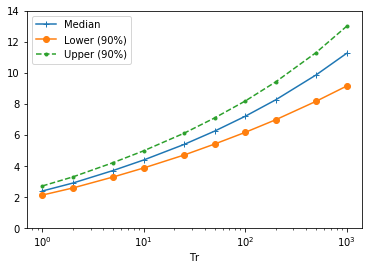

In [5]:
raw_precip = get_input_data(precip_table_dir, duration, lower_limit, display_print)
raw_precip.rename(columns = {'Expected Value':'Median'}, inplace = True)
raw_precip.plot(style=['+-','o-','.--'], logx=True, ylim=(0, 14))
raw_precip.head(2)

#### Fit GEV to rainfall data (find GEV parameters):

In [6]:
## Reduce precipitation by aerial reduction factor:
raw_precip_reduced = raw_precip[raw_precip.select_dtypes(include=['number']).columns] * Aerial_Reduction

## Find GEV parameter values:
df_GEV_parameters_M = GEV_parameters_Fit(raw_precip_reduced, 'Median', PMP)
df_GEV_parameters_U = GEV_parameters_Fit(raw_precip_reduced, 'Upper (90%)', PMP)
df_GEV_parameters_L = GEV_parameters_Fit(raw_precip_reduced, 'Lower (90%)', PMP)
df_GEV_parameters = pd.concat([df_GEV_parameters_M, df_GEV_parameters_L, df_GEV_parameters_U], axis=1)
df_GEV_parameters

,GEV Median,GEV Lower (90%),GEV Upper (90%)
mu,2.755150,2.446070,3.139833
sigma,0.574647,0.532820,0.627433
xi,-0.204410,-0.163136,-0.222317


#### Plot fitted GEV distribution and NOAA data:

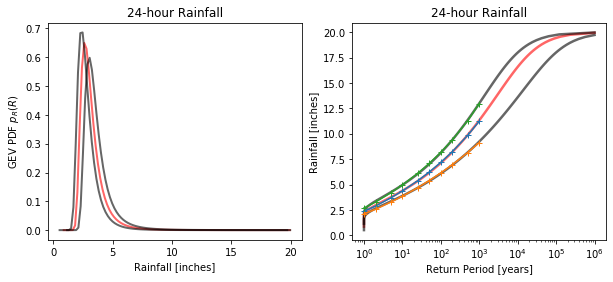

In [7]:
plot_GEV_precip_curves(raw_precip_reduced, df_GEV_parameters, PMP)

#### Data for calculating the mean curve:

In [8]:
return_interval_data = return_interval_data(raw_precip_reduced, return_intervals_mc, df_GEV_parameters, PMP)
return_interval_data.head(2)

,Median,Lower (90%),Upper (90%),Log SD (Lower),Log SD (Upper),Max Log SD,mu LN
1.00,2.379714,2.117918,2.702459,0.070849,0.077314,0.077314,0.866980
1.01,2.000418,1.724906,2.326368,0.090081,0.091764,0.091764,0.693356


#### Input for calculating the mean curve:

In [9]:
mean_curve_data = mean_curve_input_table(CL, return_interval_data, PMP, outputs_dir, Project_Area, Pluvial_Model, BCN)
mean_curve_data.head(2)

,0.001,0.005,0.010,0.050,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900,0.950,0.990,0.995,0.999
AEP,,,,,,,,,,,,,,,,,
1.000000e-07,19.970397,19.975902,19.978447,19.984881,19.987934,19.991209,19.993246,19.994756,19.995968,19.996987,19.997870,19.998653,19.999358,19.999686,19.999938,19.999969,19.999994
2.000000e-07,19.925614,19.937968,19.943796,19.958977,19.966486,19.974844,19.980253,19.984390,19.987806,19.990756,19.993378,19.995758,19.997953,19.998993,19.999801,19.999901,19.999980


---
## Hydrology 2
### Load Mean Curve:

,Expected Value,Median
Tr,,
1.111111,2.372917,2.314617
2.000000,2.954968,2.891592


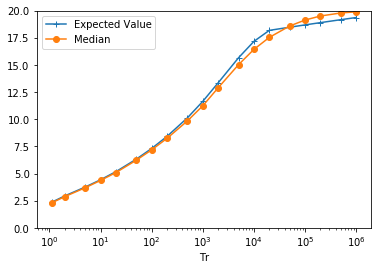

In [10]:
mean_curve_precip = pd.read_csv(precip_mean_curve_table_dir, index_col=0)
mean_curve_precip['Tr'] = 1.0/mean_curve_precip.index.values
mean_curve_precip.set_index('Tr', inplace = True)
mean_curve_precip.rename(columns = {'Q_Mean_cfs': 'Expected Value', 'Q_Median_cfs': 'Median'}, inplace = True)
mean_curve_precip.plot(style=['+-', 'o-'], logx=True, ylim=(0, PMP))
mean_curve_precip.head(2)

### Fit GEV to Mean Precipication Curve (Find GEV Parameters):

In [11]:
fit_values_mean_curve_precip = mean_curve_precip[1:20000] # Only fit the value up to about the 20,000 year event
df_GEV_parameters_E = GEV_parameters_Fit(fit_values_mean_curve_precip, 'Expected Value', PMP)
GEV_parameters_E = df_GEV_parameters_E.values.transpose()[0]
df_GEV_parameters = pd.concat([df_GEV_parameters, df_GEV_parameters_E], axis=1)
df_GEV_parameters 

,GEV Median,GEV Lower (90%),GEV Upper (90%),GEV Expected Value
mu,2.755150,2.446070,3.139833,2.738182
sigma,0.574647,0.532820,0.627433,0.584266
xi,-0.204410,-0.163136,-0.222317,-0.213904


#### Plot fitted GEV distribution and mean precipitation curve:

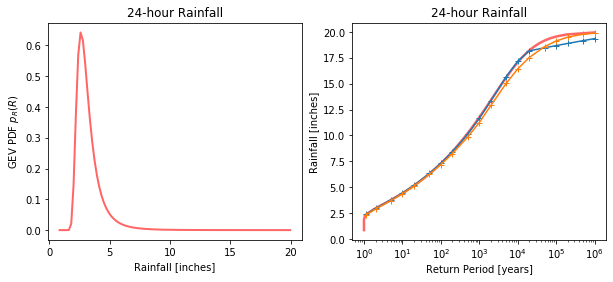

In [12]:
plot_GEV_precip_curves(mean_curve_precip, df_GEV_parameters_E, PMP)

### Hydrology 2 Events:

In [13]:
df_weights_rainfall = weights_Rainfall(Return_Intervals, GEV_parameters_E, PMP, RI_upper_bound, mean_curve_precip, 'Expected Value', RI_data, CN, mu)
df_weights_rainfall.head(2)

,Bin Floor,Bin Ceiling,Event Weight,Expected Value,Runoff
2.0,1.261016,4.091117,0.548579,2.954968,0.829794
5.0,4.091117,6.280232,0.085202,3.765830,1.361735


---
## Hydrology 3:
### Retrieve Max Potential Retention Variability and Distribution Parameters:

In [ ]:
## NRCS value of wet and dry soil moiture conditions:
arc_data = get_CN_distribution(datarepository_dir, CN_Distribution, CN, display_print)

## Table of wet, dry, and average (or median) soil moisture conditions:
df_CN = prep_cn_table(CN, arc_data)  

## Table of parameters for best fit of beta-type distribution to NRCS estiamted dispersion:
fitted_cn = find_optimal_curve_beta_dist_S(df_CN)

## Distribution parameter values:
S_limit = 1000.0/fitted_cn.iloc[0]['CN Lower Limit']-10.0
alpha = fitted_cn.iloc[0]['alpha']
beta = fitted_cn.iloc[0]['beta']

## Define probability for each partition of the max potential retention distribution:
Delta_P = 1/n_partition

## Find the average value over each partition, which is the basis for the runoff distribution:
partition_avg = partition_S_avgs(n_partition, alpha, beta, S_limit)
print(partition_avg )

fitted_cn['mu'] = mu
print(display(fitted_cn))

plot_runoff_maxRetention_distributions(GEV_parameters_E, PMP, fitted_cn)

## Runoff as a function of the return period

In [ ]:
#error between the integral approach (based on summation integration) and the actual value
error_PQ = 1- CDF_Q(PMP, mu, alpha, beta, S_limit, GEV_parameters_E, PMP, partition_avg, Delta_P)

print('\nProbability of zero runoff = {}\nError in calculation of Probabilibity of zero runoff = {}\n'
      'Error, i.e., the difference between 1 and the numerical CDF evaluated at PMP, Error = {}'
      ''.format(P_Qzero(mu, alpha, beta, S_limit, GEV_parameters_E, PMP)[0], P_Qzero(mu, alpha, beta, S_limit, GEV_parameters_E, PMP)[1], error_PQ))

### Determine Runoff Values and Weights
- Runoff weights calculated starting from a given bin ceiling.

In [ ]:
#tck_RI_Q, tck_Q_RI respectively are cubic spline interpolation functions for runoff as a function of return period and return period as a function of runoff, respectively.
tck_RI_Q, tck_Q_RI, df_weights_runoff = runoff(Return_Intervals, RI_upper_bound, mu, GEV_parameters_E, PMP, alpha, beta, S_limit, partition_avg, Delta_P, error_PQ)
df_weights_runoff

### Plot runoff distribution

In [ ]:
plot_runoff_distributions_final(GEV_parameters_E, PMP, fitted_cn, partition_avg, Delta_P, tck_RI_Q)

### Plot maximum potential distribution conditional on runoff

In [ ]:
plot_max_potential_retention_cond_runoff(GEV_parameters_E, PMP, fitted_cn, partition_avg, Delta_P)

### Calculate Runoff and Corresponding Max. Potential Retention and Rainfall

In [ ]:
df_runoff_SR1 = Scenarios_Avg_S_Median_S(df_weights_runoff, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha, beta, S_limit)
df_runoff_SR1

## Hydrology 3 Events
- For each runoff value, two events are considered, a high max. potential retention, and a low max. potential retention

In [ ]:
df_runoff_SR2 = Scenarios_low_and_high_S(df_runoff_SR1, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha,beta,S_limit)
df_runoff_SR2

---